# Pretrained Face Segmentation (BiSeNet)

In [1]:
from utils import *
from models import load_bisenet_model
import time

print(f"Using device: {device}")

Using device: cuda


BISENET EVALUATION METRICS
Mean IoU:              0.7824
Mean F1 Score:         0.8486
Mean Dice Coefficient: 0.8486
Inference Time:        0.0078s (127.4 FPS)
✓ Saved to: ../../Report/results/bisenet_results.png


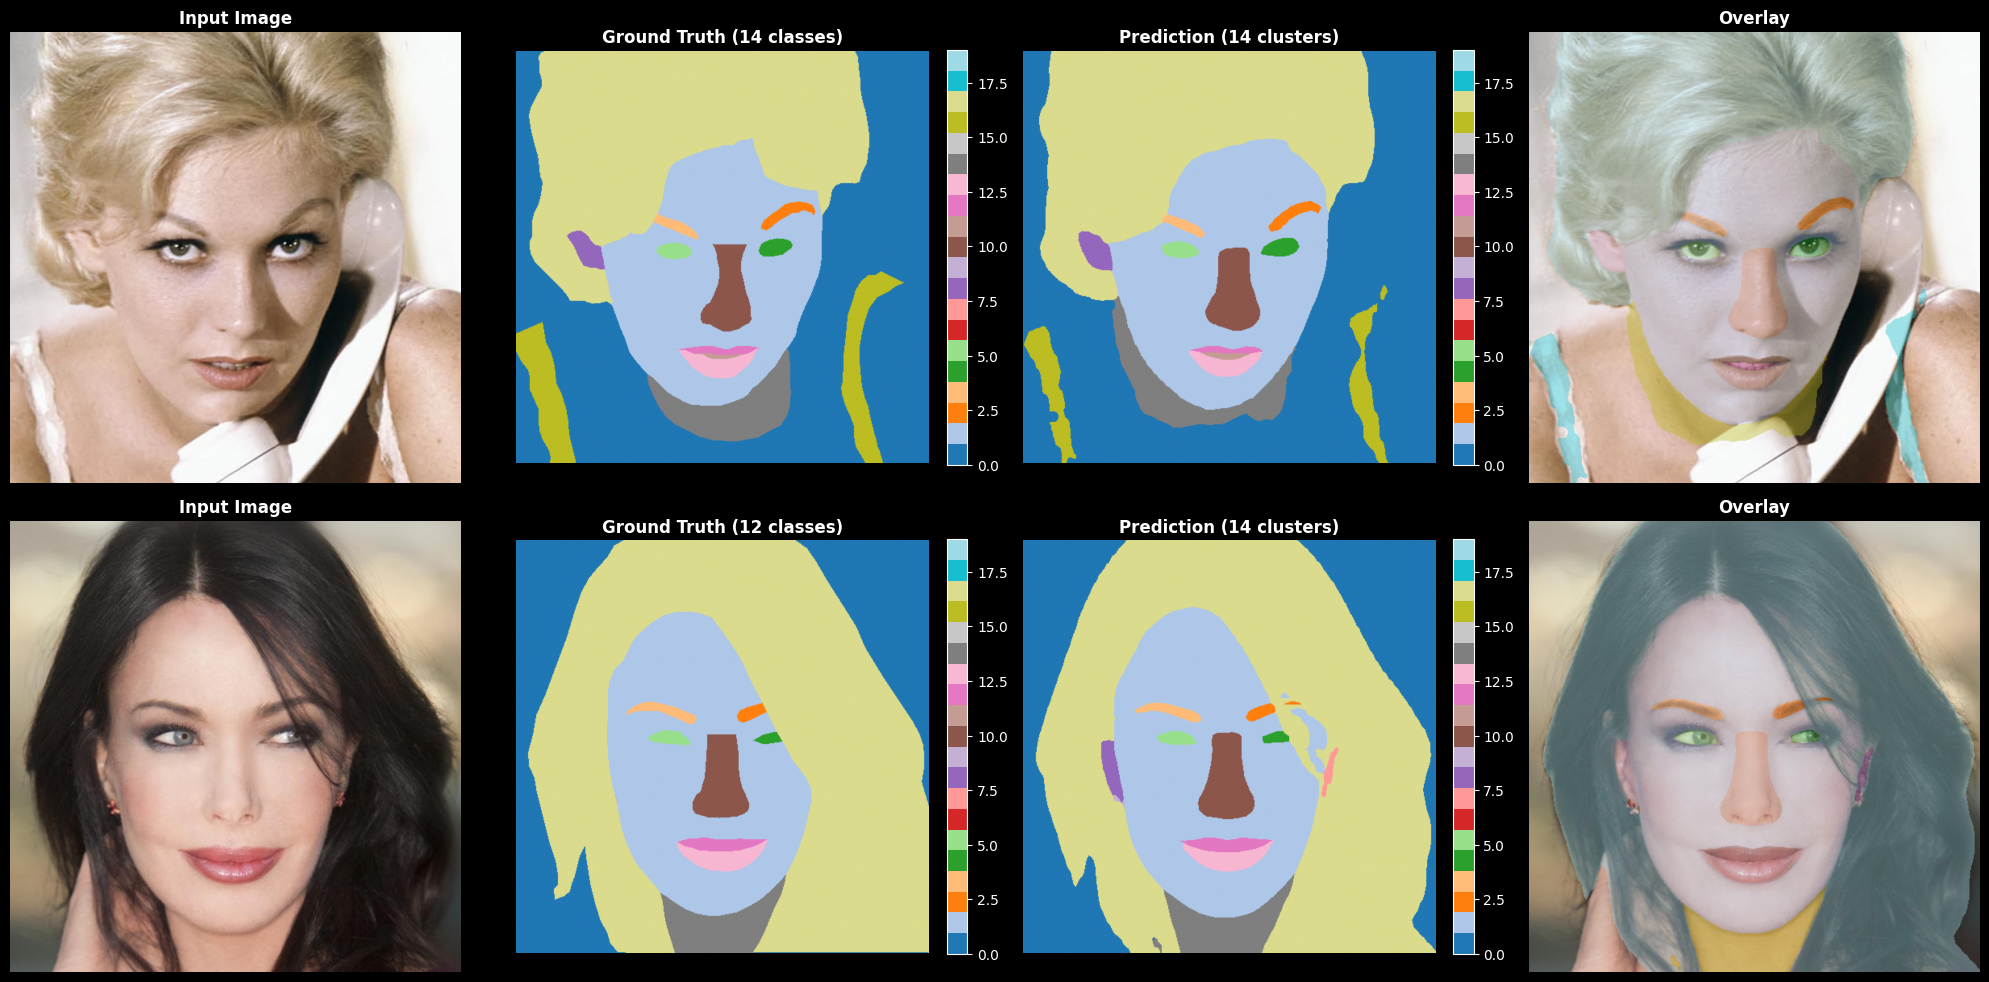


✓ Metrics saved to ../../Report/results/bisenet_metrics.csv


In [2]:
test_images, test_masks, _ = load_dataset(
    dataset_name='celebamask', 
    num_samples=40, 
    random_sample=True
)

model_path = RESULTS_DIR / 'bisenet_79999_iter.pth'
bisenet_model = load_bisenet_model(model_path, device)

def preprocess_for_bisenet(image):
    img_resized = cv2.resize(image, (512, 512))
    img_tensor = torch.from_numpy(img_resized).float()
    img_tensor = img_tensor.permute(2, 0, 1) / 255.0
    
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
    img_tensor = (img_tensor - mean) / std
    
    return img_tensor.unsqueeze(0).to(device)

def bisenet_predict(model, image):
    original_size = image.shape[:2]
    img_tensor = preprocess_for_bisenet(image)

    with torch.no_grad():
        output = model(img_tensor)
        if isinstance(output, (tuple, list)):
            output = output[0]
        pred = output.argmax(dim=1).squeeze(0).cpu().numpy()

    pred_resized = cv2.resize(pred.astype(np.uint8),
                             (original_size[1], original_size[0]), 
                             interpolation=cv2.INTER_NEAREST)
    return pred_resized

predictions = []
inference_times = []
metrics_list = []

for img, gt_mask in zip(test_images, test_masks):
    start_time = time.time()
    pred_mask = bisenet_predict(bisenet_model, img)
    inference_times.append(time.time() - start_time)
    
    predictions.append(pred_mask)
    metrics = calculate_semantic_metrics(pred_mask, gt_mask)
    metrics_list.append(metrics)

avg_metrics = {
    'mean_iou': np.mean([m['mean_iou'] for m in metrics_list]),
    'mean_f1': np.mean([m['mean_f1'] for m in metrics_list]),
    'mean_dice': np.mean([m['mean_dice'] for m in metrics_list]),
    'inference_time': np.mean(inference_times)
}

print("="*70)
print("BISENET EVALUATION METRICS")
print("="*70)
print(f"Mean IoU:              {avg_metrics['mean_iou']:.4f}")
print(f"Mean F1 Score:         {avg_metrics['mean_f1']:.4f}")
print(f"Mean Dice Coefficient: {avg_metrics['mean_dice']:.4f}")
print(f"Inference Time:        {avg_metrics['inference_time']:.4f}s ({1/avg_metrics['inference_time']:.1f} FPS)")
print("="*70)

visualize_predictions(
    images=test_images,
    true_masks=test_masks,
    predictions=predictions,
    num_samples=2,
    save_path=RESULTS_DIR / 'bisenet_results.png'
)

import pandas as pd
metrics_df = pd.DataFrame([{
    'Method': 'BiSeNet (Pretrained)',
    'Mean_IoU': avg_metrics['mean_iou'],
    'Mean_F1': avg_metrics['mean_f1'],
    'Mean_Dice': avg_metrics['mean_dice'],
    'Inference_Time_s': avg_metrics['inference_time']
}])
metrics_df.to_csv(RESULTS_DIR / 'bisenet_metrics.csv', index=False)
print(f"\n✓ Metrics saved to {RESULTS_DIR / 'bisenet_metrics.csv'}")

### Analysis

BiSeNet (Bilateral Segmentation Network) is a pretrained deep learning model achieving excellent performance (IoU ≈ 0.78, F1 ≈ 0.85) with real-time inference speed (127 FPS). The model uses a bilateral architecture combining a Spatial Path for fine details and a Context Path with ResNet18 backbone for semantic understanding, fused through an attention-based Feature Fusion Module. Pretrained on CelebAMask-HQ dataset (30,000 images), it provides zero-shot face parsing without requiring training, making it ideal when labeled data is unavailable. The model handles diverse real-world conditions including variations in lighting, pose, demographics, and image quality. Key strengths include immediate deployment capability, robust generalization, production-ready quality, and real-time processing suitable for video applications. Main limitations are the larger model size (~50-100MB) compared to lightweight alternatives, fixed architecture optimized specifically for face parsing (cannot handle general segmentation or custom classes without retraining), and potential struggles with extreme angles, heavy occlusions, or very low resolution images. This method significantly outperforms both classical unsupervised approaches and supervised YOLO-Seg, demonstrating the value of large-scale pretraining for semantic segmentation tasks.